In [1]:
# Basic Imports
import numpy as np
import h5py as h5
import pandas as pd
from scipy import stats
import pickle
import re
import collections
import tables as tb
from math import isnan
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
############################################
#STAGE 1: Data import and K-Fold creation
#Need to do this only once for given dataset
############################################

In [4]:
# Data imports
# Naming for book-keeping of your experiments
my_name = 'Exp1'
cohort = 'PNC'
clinical_scale = 'PRIME'
exp_name = '{}_{}_{}'.format(my_name,cohort,clinical_scale)

print 'Experiment Name: {}'.format(exp_name)

baseline_dir = '/projects/nikhil/PNC/'  #Directory where you have all your data
csv_file = 'data/prime_wo_age.csv'  
csv_data = pd.read_csv(baseline_dir+csv_file)

Experiment Name: Exp1_PNC_PRIME


In [5]:
# Pick Specific columns that become your input variable / features (X) and labels (y)

feature_cols = csv_data.columns[1:13]
label_col = csv_data.columns[13]
X = csv_data[feature_cols].values
y = csv_data[label_col].values

print 'X shape: {}, y shape: {}'.format(X.shape, y.shape)
print 'Mean of each feature across all subjects: {}:'.format(np.mean(X, axis=0))
print 'y_mean: {}'.format(np.mean(y))

X shape: (8498, 12), y shape: (8498,)
Mean of each feature across all subjects: [ 1.14262179  0.46999294  0.39020946  0.5913156   1.05001177  0.36573311
  0.44351612  0.47975994  0.60896682  0.53389033  0.48352554  0.27241704]:
y_mean: 0.181689809367


In [11]:
# Create folds for CV (default Stratified based on DX)
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold

stratified_KF = True
if not stratified_KF:
    print 'K-Fold type: {}'.format('Simple')
    kf = KFold(len(y), n_folds=10)
else: 
    print 'K-Fold type: {}'.format('Stratified')
    kf = StratifiedKFold(y, n_folds=10)

print ''
print "fold-wise statstics of output variable (sanity check)"
fid = 0
for train_index, test_index in kf:    
    fid +=1 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    print 'fold # {}, y_train_mean: {}, y_test_mean: {}'.format(fid, np.mean(y_train),np.mean(y_test))
    
save_experimental_setup = False  #Saves X, y, and KF
if save_experimental_setup:
    save_path = '{}exp_setup/CV_{}.pkl'.format(baseline_dir,exp_name)
    exp_setup = {'X': X, 'y': y, 'kf':kf,'exp_name':exp_name}
    pickleIt(exp_setup, save_path)
    print 'Saving experimental setup at : {}'.format(save_path)

K-Fold type: Stratified

fold-wise statstics of output variable (sanity check)
fold # 1, y_train_mean: 0.181639858768, y_test_mean: 0.1821386604
fold # 2, y_train_mean: 0.181639858768, y_test_mean: 0.1821386604
fold # 3, y_train_mean: 0.181639858768, y_test_mean: 0.1821386604
fold # 4, y_train_mean: 0.181639858768, y_test_mean: 0.1821386604
fold # 5, y_train_mean: 0.181723101059, y_test_mean: 0.181389870436
fold # 6, y_train_mean: 0.181723101059, y_test_mean: 0.181389870436
fold # 7, y_train_mean: 0.181723101059, y_test_mean: 0.181389870436
fold # 8, y_train_mean: 0.181723101059, y_test_mean: 0.181389870436
fold # 9, y_train_mean: 0.181723101059, y_test_mean: 0.181389870436
fold # 10, y_train_mean: 0.181723101059, y_test_mean: 0.181389870436


In [ ]:
############################################
#STAGE 2: Define and run ML models
# This runs on experimental setup created in STAGE 1
############################################

In [19]:
# Configs for K-fold validations (nested)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Train and Test models
from functools import partial #Parallelize!!! 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline
plt.style.use('ggplot')

In [20]:
#Pick model with its configs/hyper-params
model_list = ['LR_L1', 'RFC']
model_choice_id = 1
model_choice = model_list[model_choice_id]

if model_choice == 'LR_L1':
    model_clf = LogisticRegression(penalty='l1',n_jobs=4,class_weight='balanced')
    hyper_params = {'C':[0.01,.1,1,10]} 
    scale_data = False #Scales features (z-score)
    inner_loop = True #only needed to optimize hyper-params
    compute_feat_imp = True #The learned weights of each variable
        
elif model_choice == 'SVR':
    model_clf = SVR()
    hyper_params = {'kernel':['linear','rbf'], 'C':[1,10,25]}
    scale_data = True #Scales HC and CT features
    inner_loop = True #only needed to optimize hyper-params
    compute_feat_imp = False
           
elif model_choice == 'RFC':    
    model_clf = RandomForestClassifier(n_jobs=4,class_weight='balanced' )
    hyper_params = {'n_estimators':[10,25,50],'min_samples_split':[2,4,8]}    
    scale_data = False
    inner_loop = True #only needed to optimize hyper-params
    compute_feat_imp = True   #RF oob based feature importance
    
else:
    print "Unknown model choice"

In [28]:
# Load save experimental setup
baseline_dir = '/projects/nikhil/PNC/'
exp_setup_path = '{}exp_setup/CV_Exp1_PNC_PRIME.pkl'.format(baseline_dir)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

X_raw = exp_setup['X']

if scale_data:
    X = preprocessing.scale(X_raw)
else:
    X = X_raw
    
print 'X shape {}'.format(X.shape)

y = exp_setup['y']
kf = exp_setup['kf']
exp_name = exp_setup['exp_name']

# train a new classifer? Or load a single pretrained classifier for some testing?
# This will NOT load K different classifiers each for outer-CV fold  
train_clf = True

if train_clf:
    # Create list of all the fold-subsets (needed for parallelization)
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []    
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])
    
    # Parallization configs for ipython notebook cluster    
    rc = ipp.Client()
    dview = rc[:]
    dview.push(dict(computeOuterFold = computeOuterFold))
    dview.push(dict(innerCVLoop = innerCVLoop))
    mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, inner_loop=inner_loop, 
                  model_type=model_choice)
    parallel_result = dview.map_sync(mapfunc, X_train, y_train, X_valid, y_valid)    
    
    hp_dict = collections.defaultdict(list)
    
print "Succefully completed K-Fold training / testing"
 

X shape (8498, 12)
Succefully completed K-Fold training / testing


In [42]:
# Compute various statistics on the predicted results acorss 10 Folds    
predicted_CV_scores = []
actual_CV_scores = []
CV_Acc_valid=[] #Acuracy
CV_CM_valid=[] #Confusion matrix
CV_AUC_valid=[] #ROC and AUC       
CV_fpr_tpr = []
CV_fpr_tpr_thrsh = []
CV_feat_imp = []

for pr in parallel_result:
    y_pred_score = pr['predicted_fold_score']
    y_pred_prob = pr['predicted_fold_prob']
    y_act = pr['actual_fold_scores']
    predicted_CV_scores.append(y_pred_score)
    actual_CV_scores.append(y_act)        

    #Acc    
    CV_Acc_valid.append(acc(y_pred_score,y_act))                

    #Roc - Auc
    fpr, tpr, thresholds = roc_curve(y_act, y_pred_prob[:,1]) 
    CV_fpr_tpr.append((fpr,tpr))        
    CV_fpr_tpr_thrsh.append(thresholds)
    CV_AUC_valid.append(roc_auc_score(y_act, y_pred_prob[:,1]))

    #confusion matrix
    cm = confusion_matrix(y_pred_score,y_act)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    CV_CM_valid.append(cm_normalized)
    
    #Feature importances
    CV_feat_imp.append(pr['feat_imp'])

    for hp in hyper_params:
        hp_dict[hp].append(pr['hp_dict'][hp])

#Find out most frequent hyper-params during cross-val    
hp_mode = {}
for hp in hyper_params:
    hp_mode[hp] = mode(hp_dict[hp])[0][0]

print 'most frequent hyper-params:' + str(hp_mode)
print 'CV Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_valid),stats.sem(CV_Acc_valid))
print 'CV AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_valid),stats.sem(CV_AUC_valid))
print 'CV Confusion Matrix (mean): {}'.format(np.mean(np.array(CV_CM_valid),axis=0))

most frequent hyper-params:{'n_estimators': array([50]), 'min_samples_split': array([2])}
CV Acc (mean, std_err): 0.92, 0.00
CV AUC (mean, std_err): 0.90, 0.01
CV Confusion Matrix (mean): [[ 0.94020125  0.05979875]
 [ 0.15808843  0.84191157]]


In [45]:
# Save CV results to a file
save_model_path = baseline_dir + 'exp_results/'
exp_name = 'Exp1' #Bookkeeping 

save_CV_perf = True
if save_CV_perf:
    ts = time.time() #timestamp to prevent overwritting
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    save_model_filename = save_model_path + model_choice + '_' + exp_name + '_' + st + '.pkl'
    classifier_model_and_stats = {'opt_clf_hyperparams':hp_mode, 'CV_Acc_valid':CV_Acc_valid, 'CV_CM_valid':CV_CM_valid,
                                 'CV_AUC_valid':CV_AUC_valid, 'CV_fpr_tpr':CV_fpr_tpr, 'CV_fpr_tpr_thrsh':CV_fpr_tpr_thrsh,
                                 'CV_feat_imp':CV_feat_imp}    
    pickleIt(classifier_model_and_stats,save_model_filename)

plotting :ROC


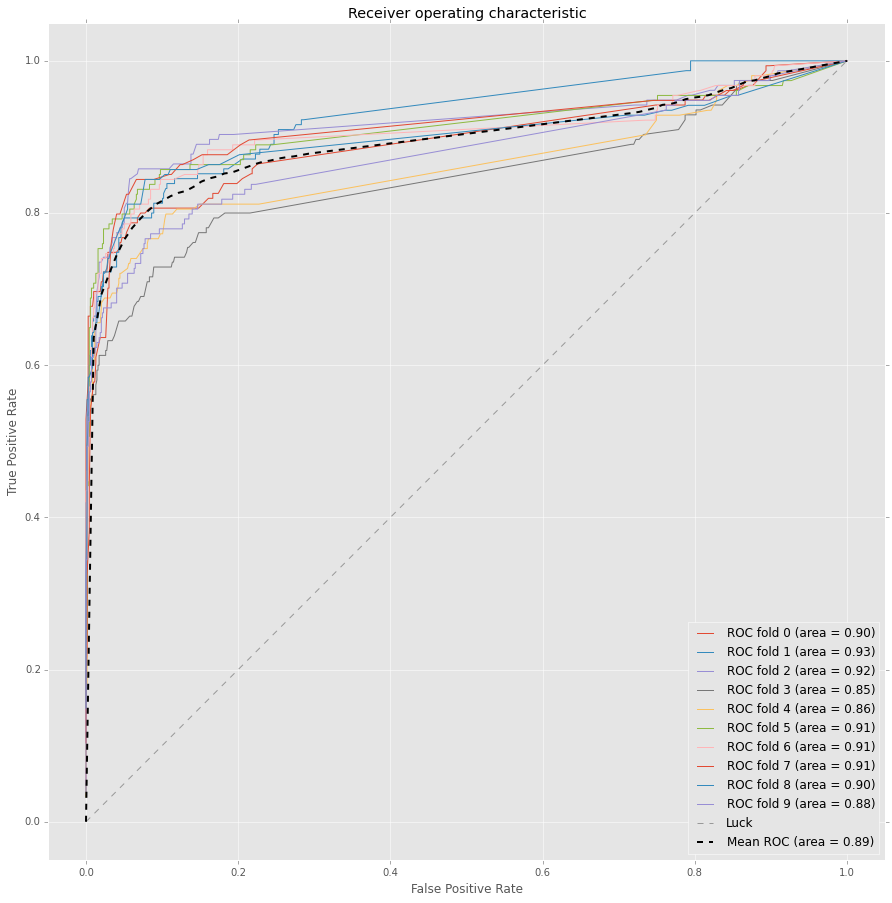

In [46]:
#plots
plt.style.use('ggplot') # Good looking plots
fontsize_large = 24
fontsize_mid = 20
n_folds = len(CV_feat_imp)
cols = 2
rows = np.ceil(n_folds/cols)

save_fig = False 
save_model_path = baseline_dir + 'exp_results/'

#Pick 1 figure to plot:
plot_feat_imp = False
plot_CM = False
plot_roc = True

if plot_feat_imp:
    plot_name = 'variable_importance'
    print 'plotting :{}'.format(plot_name)
    plt.rcParams['figure.figsize'] = (25, 25)
    for fid, feature_importance in enumerate(CV_feat_imp):
        # Get Feature Importance from the classifier
        # Normalize The Features
        feature_importance = np.squeeze(feature_importance)
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        plt.subplot(rows,cols,fid+1)
        #plt.figure(figsize=(16, 12))
        plt.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
        plt.yticks(pos, feature_cols[sorted_idx],fontsize=fontsize_mid)
        plt.ylabel('feature idx',fontsize=fontsize_large)
        #plt.xlabel('Variable Importance',fontsize=fontsize_large)
        plt.title('Fold # {}, Variable Importance'.format(fid+1),fontsize=fontsize_large)
        
# confusion matrix
elif plot_CM:
    plot_name = 'Confusion_Matrix'
    print 'plotting :{}'.format(plot_name)
    plt.rcParams['figure.figsize'] = (25, 25)
    class_labels = ['Control','Patient']
    for fid, cm in enumerate(CV_CM_valid):
        plt.subplot(rows,cols,fid+1)
        plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(len(class_labels))
        plt.xticks(tick_marks, class_labels)
        plt.yticks(tick_marks,class_labels, rotation=90)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.grid()
        # annotate confusion entries
        width = len(cm)
        height = len(cm[0])

        for x in xrange(width):
            for y in xrange(height):
                plt.annotate('{0:.3f}'.format(cm[x][y]), xy=(y, x), horizontalalignment='center',
                            verticalalignment='center',fontsize=fontsize_large)

#roc and auc
elif plot_roc:
    plot_name = 'ROC'
    print 'plotting :{}'.format(plot_name)
    plt.rcParams['figure.figsize'] = (15, 15)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (fpr, tpr) in enumerate(CV_fpr_tpr):                
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(CV_fpr_tpr)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
else:
    print 'No figures to plot'

#Save figure
if save_fig:
    print "saving figure to: {}".format(save_model_path)
    box_fig = plt.gcf()
    box_fig.savefig('{}{}_{}_{}.png'.format(save_model_path, model_choice,plot_name,exp_name), bbox_inches='tight')


In [27]:
# Some Defs needed to run the code above

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

#Outer Fold Computation (need the imports inside def if you want to parallelize!)
def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, inner_loop, model_type):
    import collections
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import grid_search    
    import collections
    from scipy.stats import mode    
    from scipy import stats
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    
    if inner_loop:     
        print 'Starting InnerFold computation'    
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
    
    # Fit the best model based on inner loop performance
    clf.fit(train_X,train_y)
    pred_y = clf.predict(valid_X) #Specific label value
    pred_y_prob = clf.predict_proba(valid_X) #Label probabilty (used for ROC)
    
    #feature imp (issue with the innerCVLoop)
    if model_type == 'RFC':
        feat_imp = clf.best_estimator_.feature_importances_
    elif model_type == 'LR_L1':
        feat_imp = clf.best_estimator_.coef_ 
    else: 
        print "Unknown model for computing feature importance. Setting it to zeros"
        feat_imp = np.zeros(len(pred_y))
        
    print 'Ending OuterFold computation'
    
    return {'actual_fold_scores':valid_y, 'predicted_fold_prob':pred_y_prob, 'predicted_fold_score': pred_y, 
            'hp_dict':hp_dict, 'feat_imp': feat_imp}

#Inner Fold Computation (need the imports inside def if you want to parallelize!)
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)    
        
    return clf

def autolabel(rects,_ax):
    for rect in rects:
        height = rect.get_height()
        _ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{:03.2f}'.format(height),
                ha='center',            # vertical alignment
                va='bottom',             # horizontal alignment
                fontsize = 25)
